In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

In [4]:
# Import the fourier method
from scripts.fouriermethod import SolverChebyshev

In [5]:
model_1_cube = FBRestNet(
    model_id = 'model_1_cube_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(2000,50,1,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=0.1, 
    nb_epochs=130,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=True,
    save_model=True,
    save_hist=True
    )

In [6]:
model_05_cube = FBRestNet(
    model_id = 'model_05_cube_',
    dataset_folder = '../Datasets/',
    model_folder = '../outputs/models/',
    opt_hist_folder = '../outputs/opt_hist/',
    experimentation=Physics(2000,50,1/2,1),
    nb_blocks=20,
    im_set="Set1",
    noise = 0.05,        
    constraint = 'cube',  
    train_size=400,
    val_size=200,
    batch_size=64,
    lr=0.1, 
    nb_epochs=130,
    freq_val=1,
    loss_elt=True,
    save_signals=False,
    save_outputs=True,
    save_model=True,
    save_hist=True
    )

In [7]:
noise_vec = [0.01, 0.05, 0.1, 0.5]
err_1_list = []
err_05_list = []
generator=torch.Generator()

for noise in noise_vec:

    model_1_cube.noise = noise
    generator.manual_seed(42)
    train_set_1_cube, val_set_1_cube = model_1_cube.CreateDataSet(generator)
    
    model_05_cube.noise = noise
    generator.manual_seed(42)
    train_set_05_cube, val_set_05_cube = model_05_cube.CreateDataSet(generator)

    fourier_filter_05c = SolverChebyshev(
            model_05_cube.physics.nx,
            model_05_cube.physics.m,
            model_05_cube.physics.a,
            model_05_cube.physics.p)

    fourier_filter_1c = SolverChebyshev(
            model_1_cube.physics.nx,
            model_1_cube.physics.m,
            model_1_cube.physics.a,
            model_1_cube.physics.p)

    err_1 = np.zeros(model_1_cube.physics.m)
    err_05 = np.zeros(model_05_cube.physics.m)

    for i in range(model_1_cube.physics.m):
        err_1[i], _ = fourier_filter_1c.Fourier_filter(val_set_1_cube,i/50, display=False)
        err_05[i], _ = fourier_filter_05c.Fourier_filter(val_set_05_cube,i/50, display=False)

    err_1_list.append(err_1)
    err_05_list.append(err_05)


In [16]:
np.argmin(err_1_list[0])

41

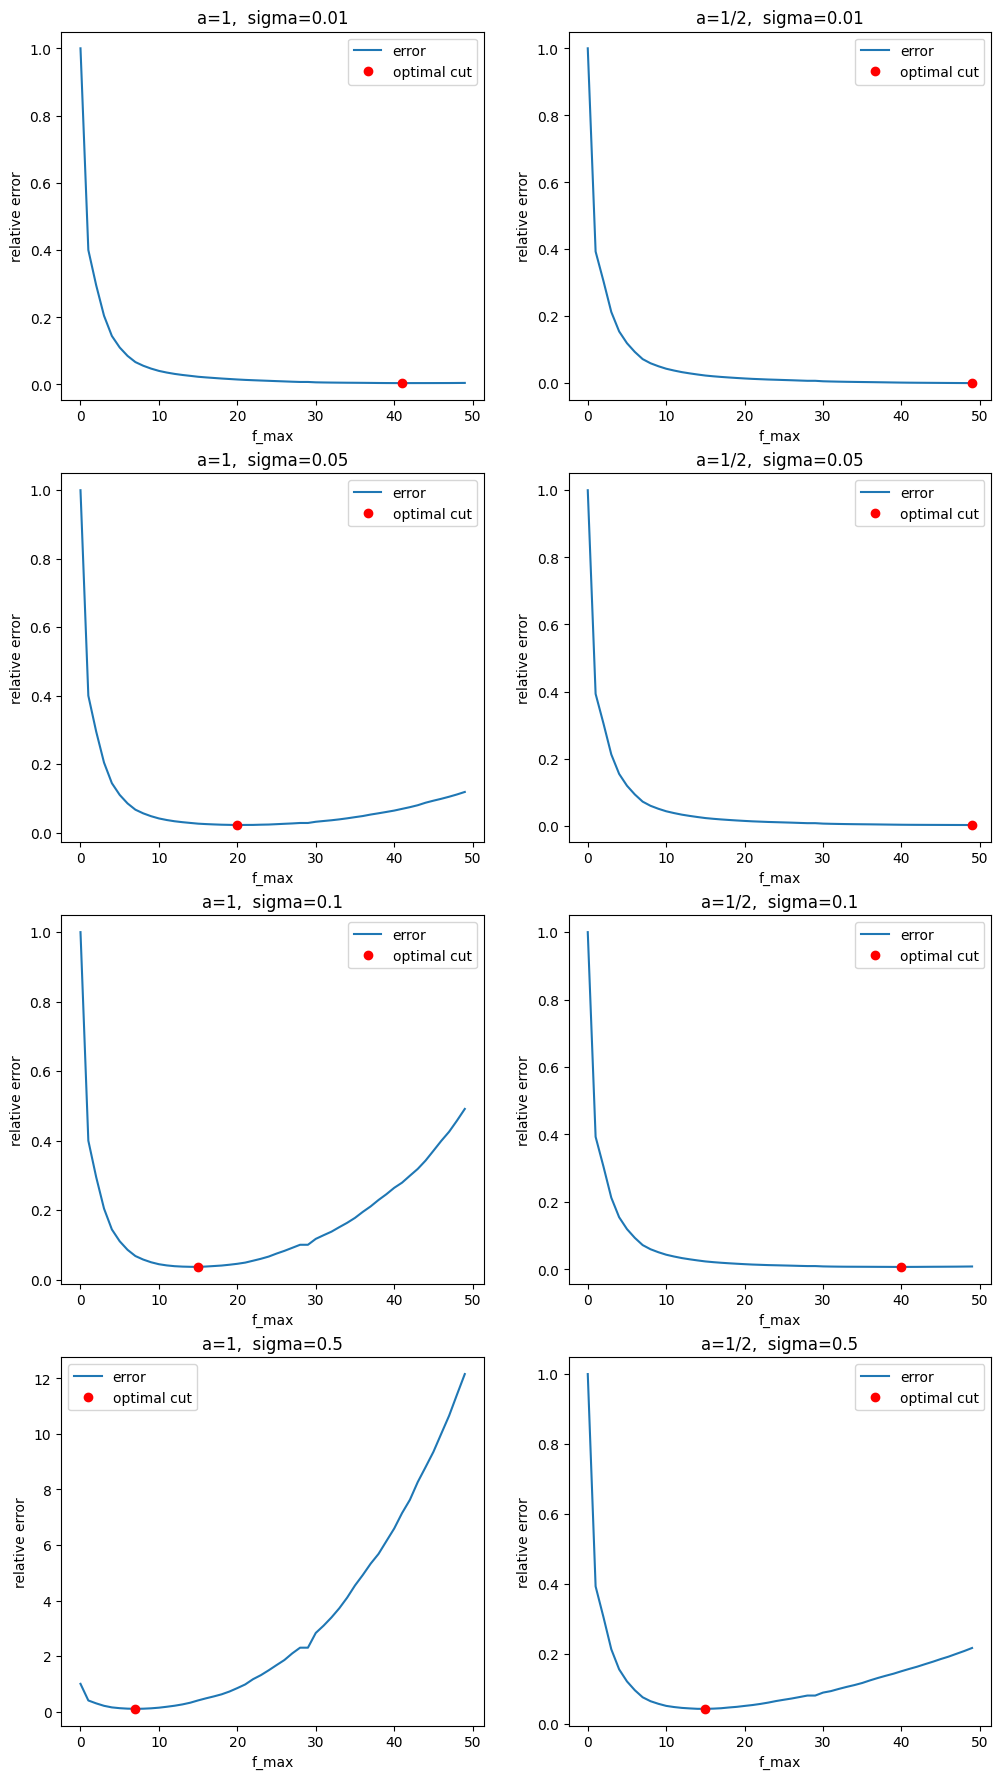

In [19]:
fig, ax = plt.subplots(4,2, figsize=(12,22))

for i, noise in enumerate(noise_vec):
    ax[i][0].plot(err_1_list[i], label='error')
    ax[i][0].set_title('a=1,  sigma={}'.format(noise))
    ax[i][0].set_xlabel('f_max')
    ax[i][0].set_ylabel('relative error')
    ax[i][0].plot(np.argmin(err_1_list[i]), np.min(err_1_list[i]), 'or', label='optimal cut')
    ax[i][0].legend()

    ax[i][1].plot(err_05_list[i], label='error')
    ax[i][1].set_title('a=1/2,  sigma={}'.format(noise))
    ax[i][1].set_xlabel('f_max')
    ax[i][1].set_ylabel('relative error')
    ax[i][1].plot(np.argmin(err_05_list[i]), np.min(err_05_list[i]), 'or', label='optimal cut')
    ax[i][1].legend()